# Residual Networks 

<b> The problems of very deep neural networks:-</b> <br>

The main benefit of a very deep network is that it can represent very complex functions. It can also learn features at many different levels of abstraction, from edges (at the lower layers) to very complex features (at the deeper layers). However, using a deeper network doesn't always help. A huge barrier to training them is vanishing gradients: very deep networks often have a gradient signal that goes to zero quickly, thus making gradient descent unbearably slow. More specifically, during gradient descent, as you backprop from the final layer back to the first layer, you are multiplying by the weight matrix on each step, and thus the gradient can decrease exponentially quickly to zero (or, in rare cases, grow exponentially quickly and "explode" to take very large values).<br>

## Building a Residual Network
Lets build residual network to classification of sign Language MNIST.<br>

In ResNets, a "shortcut" or a "skip connection" allows the gradient to be directly backpropagated to earlier layers:
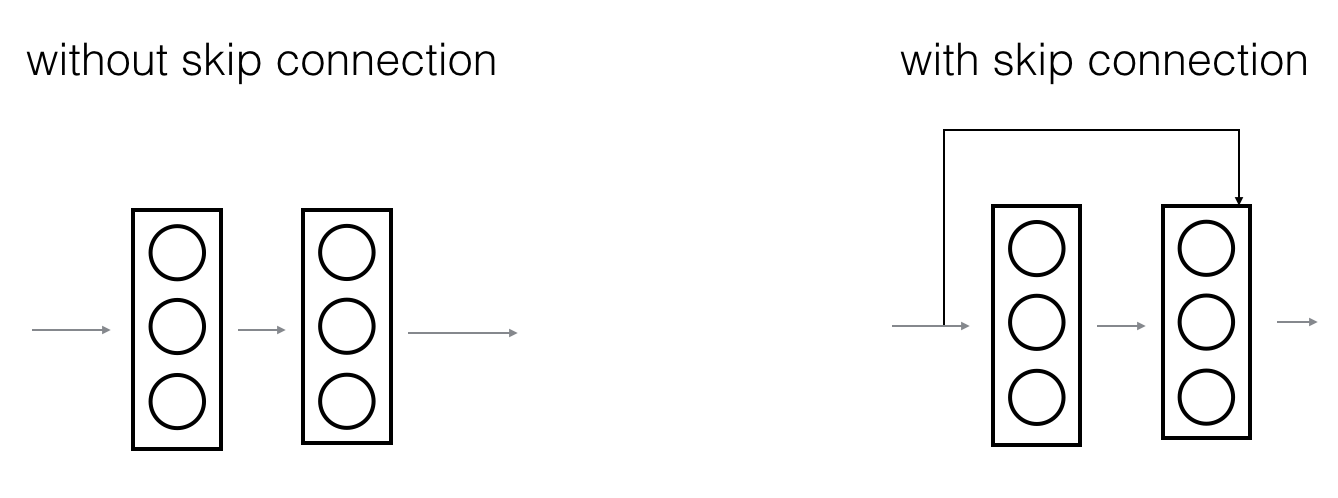

The image on the left shows the "main path" through the network. The image on the right adds a shortcut to the main path. By stacking these ResNet blocks on top of each other, you can form a very deep network.

Two main types of blocks are used in a ResNet, depending mainly on whether the input/output dimensions are same or different. You are going to implement both of them.

### The identity block

The identity block is the standard block used in ResNets, and corresponds to the case where the input activation (say $a^{[l]}$) has the same dimension as the output activation (say $a^{[l+2]}$). To flesh out the different steps of what happens in a ResNet's identity block, here is an alternative diagram showing the individual steps

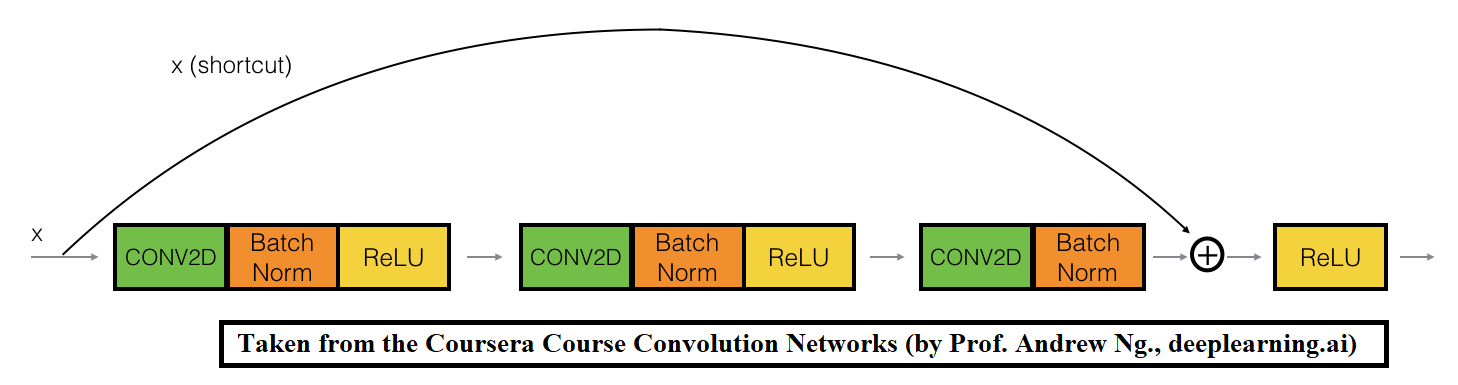

### The convolutional block
​
convolutional block is the other type of block. You can use this type of block when the input and output dimensions don't match up. The difference with the identity block is that there is a CONV2D layer in the shortcut path

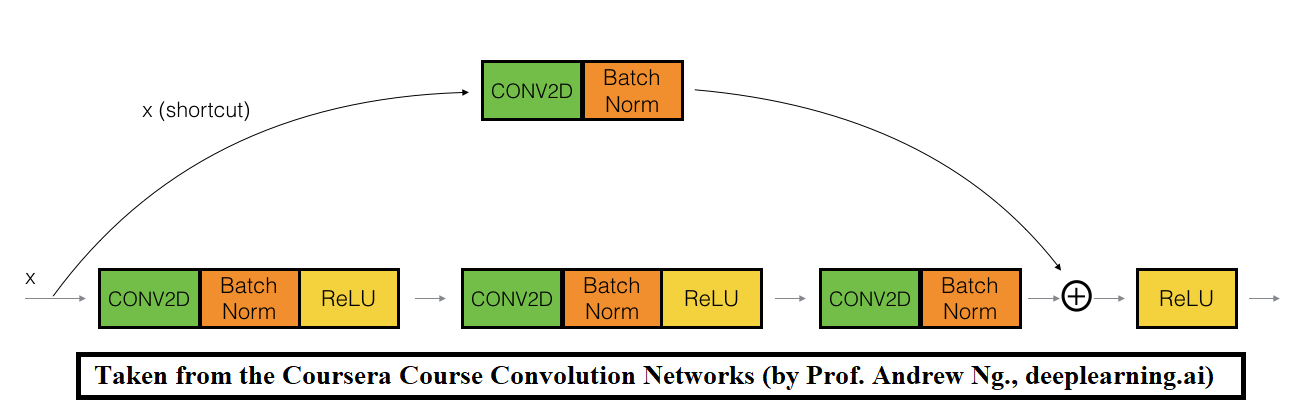

In [1]:
import tensorflow as tf
import pandas as pd
import os
import numpy as np
from tensorflow.keras.layers import Flatten,Conv2D,Dense,BatchNormalization,Activation,Input,Add,AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,ZeroPadding2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model,load_model
import matplotlib.pyplot as plt
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.datasets import cifar10

In [2]:
def identity_block(X, f, filters, stage, block):
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path 
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path 
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'same', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    #Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut]) 
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [3]:
# GRADED FUNCTION: convolutional_block

def convolutional_block(X, f, filters, stage, block, s = 2):

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(F2, (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path 
    X = Conv2D(F3, (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut]) 
    X = Activation('relu')(X)
    
    return X

## Building ResNet model (50 layers)

The details of this ResNet-50 model are:
- Zero-padding pads the input with a pad of (3,3)
- Stage 1:
    - The 2D Convolution has 64 filters of shape (7,7) and uses a stride of (2,2). Its name is "conv1".
    - BatchNorm is applied to the channels axis of the input.
    - MaxPooling uses a (3,3) window and a (2,2) stride.
- Stage 2:
    - The convolutional block uses three set of filters of size [64,64,256], "f" is 3, "s" is 1 and the block is "a".
    - The 2 identity blocks use three set of filters of size [64,64,256], "f" is 3 and the blocks are "b" and "c".
- Stage 3:
    - The convolutional block uses three set of filters of size [128,128,512], "f" is 3, "s" is 2 and the block is "a".
    - The 3 identity blocks use three set of filters of size [128,128,512], "f" is 3 and the blocks are "b", "c" and "d".
- Stage 4:
    - The convolutional block uses three set of filters of size [256, 256, 1024], "f" is 3, "s" is 2 and the block is "a".
    - The 5 identity blocks use three set of filters of size [256, 256, 1024], "f" is 3 and the blocks are "b", "c", "d", "e" and "f".
- Stage 5:
    - The convolutional block uses three set of filters of size [512, 512, 2048], "f" is 3, "s" is 1 and the block is "a".
    - The 2 identity blocks use three set of filters of size [512, 512, 2048], "f" is 3 and the blocks are "b" and "c".
- The 2D Average Pooling uses a window of shape (2,2) and its name is "avg_pool".
- The flatten doesn't have any hyperparameters or name.
- The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation. Its name should be `'fc' + str(classes)`

In [4]:
def ResNet50(input_shape = (64, 64, 3), classes = 10):
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3 
    X = convolutional_block(X, f = 3, filters = [128,128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128,128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128,128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128,128, 512], stage=3, block='d')

    # Stage 4 
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 1)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL 
    X = AveragePooling2D((2, 2), name='avg_pool')(X)
    

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [5]:
file_path='model2.hdf5'
my_check=ModelCheckpoint(file_path,
    monitor='val_accuracy',
    verbose=0,
    save_best_only=True)

##### Let's load the SIGNS Dataset.

In [6]:
train=pd.read_csv("datasets/sign_mnist_train.csv")
test=pd.read_csv("datasets/sign_mnist_test.csv")

In [7]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [8]:
# i will take only 3 signs from datasets 
train=train[(train['label']==0)|(train['label']==1)|(train['label']==2)]
test=test[(test['label']==0)|(test['label']==1)|(test['label']==2)]

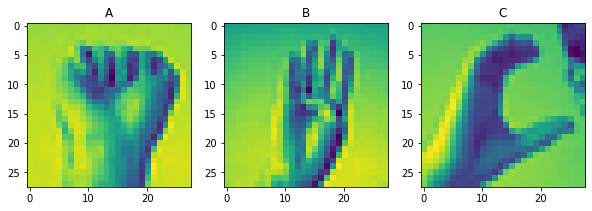

In [9]:
plt.figure(figsize=(10,15))
plt.subplot(131)
plt.imshow(train[train['label']==0].drop('label',axis=1).iloc[0,:].values.reshape(28,28))
plt.title('A')
plt.subplot(132)
plt.imshow(train[train['label']==1].drop('label',axis=1).iloc[0,:].values.reshape(28,28))
plt.title('B')
plt.subplot(133)
plt.imshow(train[train['label']==2].drop('label',axis=1).iloc[0,:].values.reshape(28,28))
plt.title('C')
plt.show()

In [10]:
set(train['label'])

{0, 1, 2}

In [11]:
X_train=train.drop(labels='label',axis=1).values.reshape(-1,28,28,1)
y_train=train['label'].values
X_test=test.drop(labels='label',axis=1).values.reshape(-1,28,28,1)
y_test=test['label'].values

In [12]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3280, 28, 28, 1)
(3280,)
(1073, 28, 28, 1)
(1073,)


In [13]:
dic={0:'A',1:'B',2:'C'}

In [14]:
y_train_cat=to_categorical(y_train,num_classes=3)
y_test_cat=to_categorical(y_test,num_classes=3)

In [15]:
model=ResNet50(input_shape=(28,28,1),classes=3)
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [16]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 34, 34, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 14, 14, 64)   3200        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 14, 14, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [17]:
model.fit(X_train,y_train_cat,validation_data=(X_test,y_test_cat),epochs=5,callbacks=[my_check])

Train on 3280 samples, validate on 1073 samples
Epoch 1/5
3280/3280 [==============================] - 80s 24ms/sample - loss: 0.2092 - accuracy: 0.9486 - val_loss: 1.3060 - val_accuracy: 0.7748
Epoch 2/5
3280/3280 [==============================] - 73s 22ms/sample - loss: 0.0150 - accuracy: 0.9965 - val_loss: 0.0205 - val_accuracy: 0.9953
Epoch 3/5
3280/3280 [==============================] - 72s 22ms/sample - loss: 0.0098 - accuracy: 0.9976 - val_loss: 0.0640 - val_accuracy: 0.9770
Epoch 4/5
3280/3280 [==============================] - 71s 22ms/sample - loss: 0.0536 - accuracy: 0.9910 - val_loss: 7.2906 - val_accuracy: 0.5259
Epoch 5/5
3280/3280 [==============================] - 72s 22ms/sample - loss: 0.0256 - accuracy: 0.9952 - val_loss: 4.0947e-04 - val_accuracy: 1.0000


In [18]:
model.load_weights(file_path)

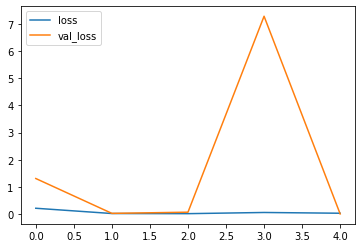

In [19]:
pd.DataFrame(model.history.history)[['loss','val_loss']].plot()

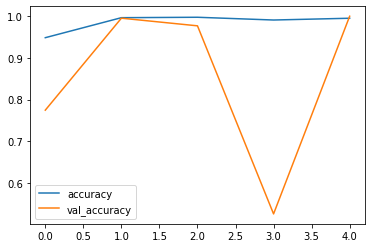

In [20]:
pd.DataFrame(model.history.history)[['accuracy','val_accuracy']].plot()

In [21]:
#model=load_model(file_path)

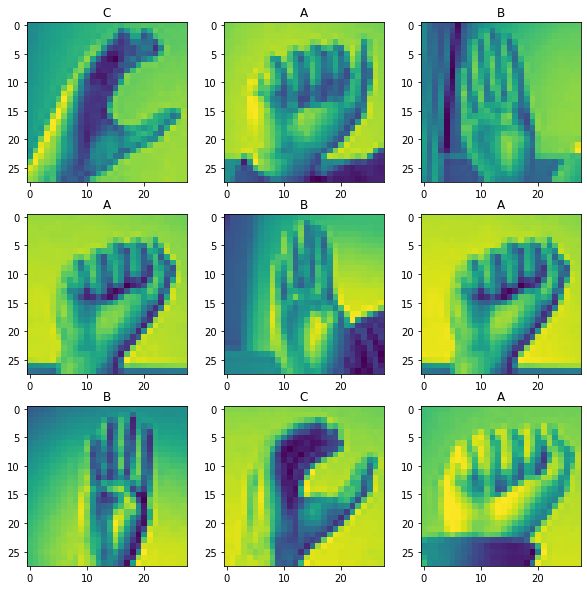

In [22]:
choosen=np.random.randint(0,1000,9)
row=3
col=3
i=0
plt.figure(figsize=(10,10))
for point in choosen:
    i=i+1
    plt.subplot(row,col,i)
    pred=model.predict(X_test[point].reshape(1,28,28,1).astype(float)).argmax()
    plt.imshow(X_test[point].reshape(28,28))
    plt.title(dic[pred])
plt.show() 